# 5) Alternative Data — ESG Incremental Alpha

> Read me
- Run top-to-bottom. Uses simulated data only (numpy/pandas/matplotlib).
- Cells with **TODO** are what interviewers often expect you to implement.
- Keep runs fast. Vectorize when possible.
- Use clean functions with docstrings; add comments where you make assumptions.


## Setup & Data (simulated)

In [90]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

np.random.seed(11)
n = 800
months = pd.period_range('2013-01','2020-12',freq='M').to_timestamp('M')
tickers = [f"U{i:04d}" for i in range(n)]
mi = pd.MultiIndex.from_product([months, tickers], names=["date","ticker"])
panel = pd.DataFrame(index=mi)
panel["value"] = np.random.normal(0,1,len(panel))
panel["quality"] = np.random.normal(0,1,len(panel))
panel["momentum"] = np.random.normal(0,1,len(panel))

theta = np.array([0.002,0.0018,0.0025])
panel["ret"] = panel[["value","quality","momentum"]].values @ theta + np.random.normal(0,0.05,len(panel))

years = pd.date_range('2012-12-31','2020-12-31',freq='A')
esg_idx = pd.MultiIndex.from_product([years, tickers], names=["date","ticker"])
esg = pd.DataFrame(index=esg_idx)
base = np.random.normal(0,1,n)
for y in years:
    base = 0.8*base + np.random.normal(0,0.6,n)
    esg.loc[(y,slice(None)),"esg_level"] = base
esg["esg_level"] = esg["esg_level"].astype(float)
# bad code to reindex esg to monthly
# esg = esg.groupby(level="ticker").apply(lambda x: x.droplevel(0).reindex(months, method="ffill")).swaplevel().sort_index()
esg = esg.unstack().reindex(months).ffill().stack().sort_index()

panel["esg_level"] = esg["esg_level"]
panel["esg_change_12m"] = panel.groupby("ticker")["esg_level"].diff(12)

def z(g): return (g - g.mean())/g.std(ddof=0)
for c in ["value","quality","momentum","esg_level","esg_change_12m"]:
    panel[c] = panel.groupby("date")[c].transform(lambda s: z(s.fillna(s.mean()))).fillna(0)
panel["fwd_ret"] = panel.groupby("ticker")["ret"].shift(-1)


/var/folders/kc/7dyzg2fs2zv9v849s3n6rd4w0000gn/T/ipykernel_48578/3835603.py:17: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  years = pd.date_range('2012-12-31','2020-12-31',freq='A')
/var/folders/kc/7dyzg2fs2zv9v849s3n6rd4w0000gn/T/ipykernel_48578/3835603.py:27: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  esg = esg.unstack().reindex(months).ffill().stack().sort_index()


## TODO Checklist
1. Run monthly **cross-sectional regressions** (Fama–MacBeth) for base styles vs base+ESG.
2. Compute **time-series means** of coefficients and **t-stats** (use simple SE over time; NW optional).
3. Report **incremental IC**: correlation of ESG-only residual with forward returns.
4. Do a simple **bucket test** on ESG level (quintiles) and plot long–short.


In [72]:
import statsmodels.api as sm

In [ ]:
def fm_beta(df, cols):
    # TODO: return Series of OLS coefficients for the month


def fm_beta_sm(df, cols):
    """
    OLS with intercept using statsmodels. Returns a DataFrame with ['coef','t'].
    """


cols_base = ["value","quality","momentum"]
cols_plus = cols_base + ["esg_level","esg_change_12m"]

betas_base = panel.dropna(subset=["fwd_ret"]).groupby("date").apply(lambda x: fm_beta_sm(x, cols_base))
betas_plus = panel.dropna(subset=["fwd_ret"]).groupby("date").apply(lambda x: fm_beta_sm(x, cols_plus))


In [92]:
# TODO 2: compute means and t-stats across months
coefs = pd.concat([betas_base['coef'].unstack().mean(), betas_plus['coef'].unstack().mean()], axis=1).rename(columns={0: 'Base', 1: 'Plus'})
coefs

,Base,Plus
const,-0.000115,-0.000115
value,-0.000085,-0.000094
quality,0.000100,0.000104
momentum,-0.000021,-0.000029
esg_level,NaN,-0.000243
esg_change_12m,NaN,-0.000179


In [93]:
tstats = pd.concat([betas_base['t'].unstack().mean(), betas_plus['t'].unstack().mean()], axis=1).rename(columns={0: 'Base', 1: 'Plus'})
tstats

,Base,Plus
const,-0.072261,-0.072372
value,-0.044263,-0.049300
quality,0.056754,0.058438
momentum,-0.010713,-0.014851
esg_level,NaN,-0.145833
esg_change_12m,NaN,-0.129815


In [ ]:
# betas_plus = ...
from scipy.stats import spearmanr

# TODO 3: incremental IC
def neutralize_beta(df, factor: str, neutralizers: list):


resid_esg = panel.loc[panel.esg_level!=0].groupby(level='date', group_keys=False).apply(lambda x: neutralize_beta(x, 'esg_level', cols_base))
panel['esg_level_resid'] = resid_esg

ic = panel.loc[panel.esg_level!=0].groupby('date').apply(lambda x : spearmanr(x.esg_level_resid, x.fwd_ret)[0]).dropna()
print("Incremental IC mean:", ic.mean())


Incremental IC mean: -0.007626943557724311


In [113]:
# TODO 4: ESG bucket backtest

panel['esg_ensemble'] = panel[['esg_level', 'esg_change_12m']].sum(axis=1)
panel_backtest = panel.loc[panel.esg_ensemble != 0].copy()
panel_backtest['tile'] = panel_backtest.groupby('date')['esg_ensemble'].transform(lambda x : pd.qcut(x.rank(method='first',pct=True), 10, labels=False))

In [ ]:
long = panel_backtest.loc[panel_backtest.tile == 9].groupby('date')['fwd_ret'].mean()
short = panel_backtest.loc[panel_backtest.tile == 0].groupby('date')['fwd_ret'].mean()
ls = long - short

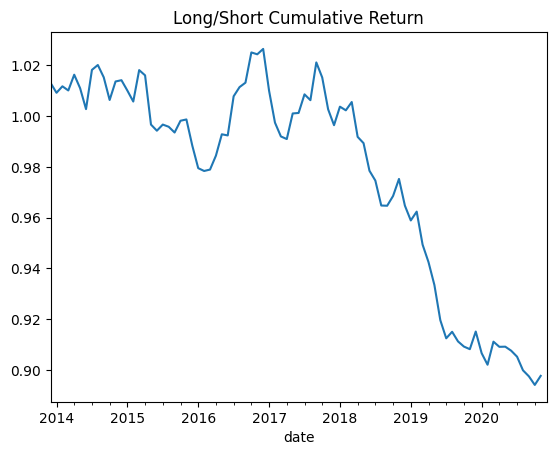

In [ ]:
# lol even AI wants to short ESG
plt.figure()
ls.add(1).cumprod().plot(title='Long/Short Cumulative Return')
plt.show()